In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/Colab Notebooks/cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

#this allows the colab VM to load the python files within it
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1


# Multiclass Support Vector Machine

    
- Implement a fully-vectorized **loss function** for the SVM
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check my implementation** using numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [ ]:
import numpy as np
import random
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [16]:
def get_cifar10_dataset(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  cifar_10_data = 'cs231n/datasets/cifar-10-batches-py'

  try:
    del X_train, y_train
    del X_test, y_test
    print('Cleared previously existing data')
  except:
    pass

  X_train, y_train, X_test, y_test = load_CIFAR10(cifar_10_data)

  mask = list(range(num_training, num_training + num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]

  #Preprocess; reshape the input data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

  #Get the mean image and subtract from dataset to normalize
  mean_image = np.mean(X_train, axis=0)
  X_train -= mean_image
  X_test -= mean_image
  X_val -= mean_image
  X_dev -= mean_image

  # Add a bias term to each dataset (as a column of ones)
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])


  return X_train, y_train, X_test, y_test, X_val, y_val, X_dev, y_dev

# Use the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_cifar10_dataset()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


SVM Classifier

In [17]:
def svm_loss_naive(W, X, y, reg):
  dW = np.zeros_like(W)
  loss = 0.0
  num_train = X.shape[0]
  num_classes = W.shape[1]

  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1
      if margin > 0:
        loss += margin
        dW[:, j] += X[i]
        dW[:, y[i]] -= X[i]

  loss/= num_train
  dW /= num_train

  #Add regularization
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg * W
  return loss, dW


In [18]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss,))

loss: 9.143301


In [19]:
# [Imported from the stanford notebook]

# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -18.566654 analytic: -18.566654, relative error: 3.229304e-12
numerical: -20.605790 analytic: -20.605790, relative error: 6.372915e-12
numerical: -14.751068 analytic: -14.751068, relative error: 6.592155e-12
numerical: -5.769399 analytic: -5.769399, relative error: 3.512011e-11
numerical: 23.953412 analytic: 23.953412, relative error: 1.622298e-12
numerical: -14.954063 analytic: -14.954063, relative error: 1.328104e-11
numerical: -12.156900 analytic: -12.156900, relative error: 2.209717e-11
numerical: 23.579528 analytic: 23.579528, relative error: 6.672546e-12
numerical: -8.438746 analytic: -8.438746, relative error: 4.869709e-11
numerical: 14.150901 analytic: 14.150901, relative error: 9.080309e-12
numerical: -29.369009 analytic: -29.369009, relative error: 1.132274e-11
numerical: 8.447068 analytic: 8.447068, relative error: 3.496999e-11
numerical: -1.513496 analytic: -1.513496, relative error: 1.781071e-10
numerical: -4.458710 analytic: -4.458710, relative error: 1.987645e

In [25]:
#This is a more effiicent version of the naive loss function i.e no for loops
def svm_loss_vectorized(W, X, y, reg):
  num_train = X.shape[0]
  scores = X.dot(W)
  correct_class_scores = scores[np.arange(num_train), y].reshape(-1,1)

  #Compute margins
  margins = np.maximum(0, scores - correct_class_scores + 1)
  margins[np.arange(num_train), y] = 0

  loss = np.sum(margins) / num_train
  loss += reg * np.sum(W * W)

  binary = margins>0
  coeff_matrix = binary.astype(float)
  row_sum = np.sum(coeff_matrix, axis=1)
  coeff_matrix[np.arange(num_train), y] = -row_sum
  dW = X.T.dot(coeff_matrix)
  dW /= num_train
  dW += 2 * reg * W
  return loss, dW


In [26]:
# [From the stanford's notebook as well]
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
import time
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic ))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.073763s
Vectorized loss and gradient: computed in 0.011533s
difference: 0.000000


# This shows how efficient the vectorized loss is. It is greater than x5 faster.

# The linear classifier

In [31]:
class LinearClassifier:
  def __init__(self):
    self.W = None #weights would be initialized during training

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
    num_train, dim = X.shape
    num_classes = np.max(y) + 1

    if self.W is None:
      self.W = 0.001 * np.random.randn(dim, num_classes)

    loss_history = []
    for it in range(num_iters):
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      loss, grad = self.loss(self.W, X_batch, y_batch, reg)
      loss_history.append(loss)

      self.W -= learning_rate * grad

      if verbose and it%100 ==0:
        print(f'iteration {it} / {num_iters}: loss {loss}')
    return loss_history

  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    scores = X.dot(self.W)
    y_pred = np.argmax(scores, axis=1)
    return y_pred

class LinearSVM(LinearClassifier):
  def loss(self, W, X, y, reg):
    return svm_loss_vectorized(W, X, y, reg)


In [32]:
svm = LinearSVM()

import time
tic = time.time()
loss_hist = svm.train(X_train, y_train,
                      learning_rate=1e-7,
                      reg=2.5e4,
                      num_iters=1500,
                      verbose=True)
toc = time.time()

print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 777.3409153772079
iteration 100 / 1500: loss 285.3510467245484
iteration 200 / 1500: loss 107.31653894085318
iteration 300 / 1500: loss 42.65733711120323
iteration 400 / 1500: loss 18.57475436778202
iteration 500 / 1500: loss 10.44585487694714
iteration 600 / 1500: loss 7.065453079930159
iteration 700 / 1500: loss 6.0764124031227285
iteration 800 / 1500: loss 5.621738860948532
iteration 900 / 1500: loss 5.463260318202888
iteration 1000 / 1500: loss 5.438937999065662
iteration 1100 / 1500: loss 5.049883854618588
iteration 1200 / 1500: loss 5.129963446311357
iteration 1300 / 1500: loss 4.793178393856512
iteration 1400 / 1500: loss 5.263543914086811
That took 11.337317s


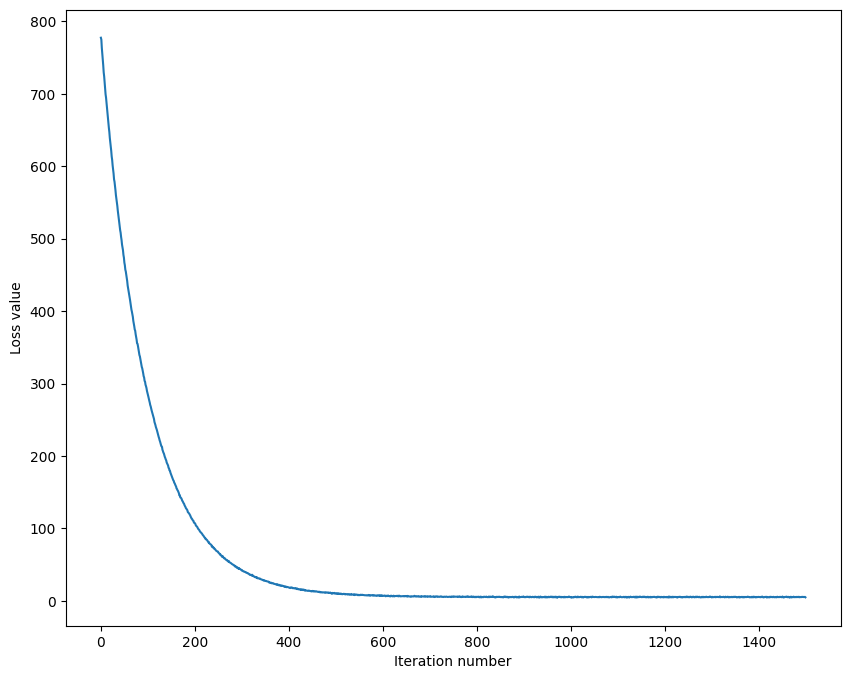

In [33]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [34]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371020
validation accuracy: 0.358000


In [36]:
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-8, 1e-7, 5e-5]
regularization_strengths = [1.5e4, 2.5e4, 5e4]


for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

<ipython-input-25-db61f1bc25dc>:12: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-25-db61f1bc25dc>:12: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
<ipython-input-25-db61f1bc25dc>:20: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
<ipython-input-31-8761bcc8215c>:21: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


lr 1.000000e-08 reg 1.500000e+04 train accuracy: 0.238776 val accuracy: 0.238000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.257102 val accuracy: 0.259000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.304245 val accuracy: 0.309000
lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.378816 val accuracy: 0.373000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.375000 val accuracy: 0.375000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.355347 val accuracy: 0.355000
lr 5.000000e-05 reg 1.500000e+04 train accuracy: 0.156347 val accuracy: 0.170000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.057755 val accuracy: 0.056000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.103000
best validation accuracy achieved during cross-validation: 0.375000


In [37]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


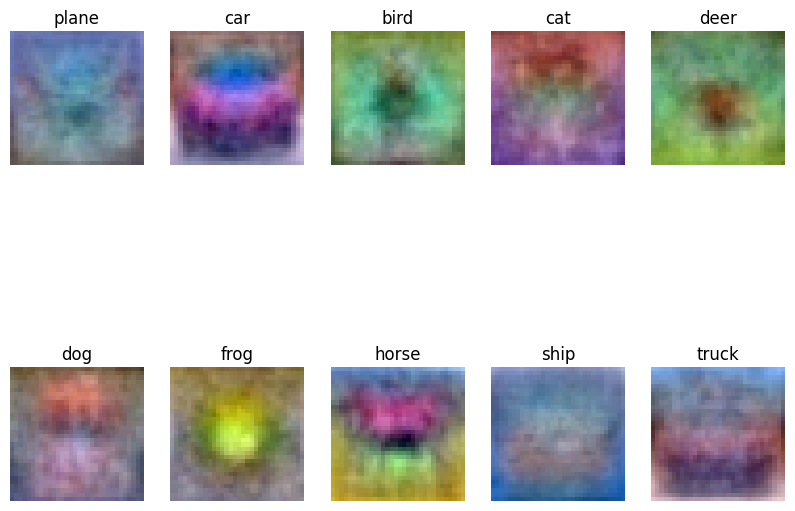

In [38]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])